# $\beta$-VAE on MNIST — Definition & Derivation

**Definition (short):** A $\beta$-VAE is a variational autoencoder regularized with a weight $\beta$ on the KL term to encourage disentangled latent representations. It optimizes a modified Evidence Lower Bound (ELBO).

**Generative model:** $p_\theta(x \mid z)$ with prior $p(z)=\mathcal{N}(0,I)$ and approximate posterior (encoder) $q_\phi(z\mid x)=\mathcal{N}(\mu_\phi(x), \operatorname{diag}(\sigma^2_\phi(x)))$.

**ELBO (per data point):**
$ \log p_\theta(x) \ge \mathbb{E}_{q_\phi(z\mid x)}[\log p_\theta(x\mid z)] - \operatorname{KL}\big(q_\phi(z\mid x)\;||\;p(z)\big). $

**$\beta$-VAE objective:** multiply the KL term by $\beta\ge1$:

$ \mathcal{L}_{\beta\text{-VAE}}(x) = -\mathbb{E}_{q_\phi(z\mid x)}[\log p_\theta(x\mid z)] + \beta\; \operatorname{KL}\big(q_\phi(z\mid x)\;||\;p(z)\big). $

- The first term is the *reconstruction loss* (e.g., Bernoulli / BCE for binarized MNIST or MSE for real-valued images).
- The second term pulls the posterior toward the prior; $\beta>1$ encourages disentanglement but may reduce reconstruction fidelity.

**Closed forms used in implementation:**

- For Gaussian approximate posterior $q_\phi(z|x)=\mathcal{N}(\mu, \operatorname{diag}(\sigma^2))$ and standard normal prior $p(z)=\mathcal{N}(0,I)$, the KL has analytic form:

$ \operatorname{KL}(q \| p) = \frac{1}{2}\sum_{j=1}^d\left(\mu_j^2 + \sigma_j^2 - \log \sigma_j^2 - 1\right). $

- For Bernoulli decoder $p_\theta(x\mid z)$ with logits $x_\text{recon\_logits}$, the reconstruction loss per image is:

$ -\mathbb{E}_{q_\phi}[\log p_\theta(x\mid z)] \approx \operatorname{BCEWithLogits}(x_\text{recon\_logits}, x). $

**Plan for the notebook:**
1. Implement a small convolutional $\beta$-VAE (encoder → latent $\mu,\log\sigma^2$, decoder).  
2. Train on MNIST while printing per-batch computation details (shapes, KL, recon loss, ELBO).  
3. Visualize reconstructions, latent scatter (2D) and 3D plots, latent traversals, and interpolations.  
4. Provide tips for tuning $\beta$ and training longer for disentanglement.


In [9]:
# Cell 2 — imports and config (run first)
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, utils
import matplotlib.pyplot as plt
import numpy as np
import os
from tqdm import tqdm

# reproducibility
torch.manual_seed(0)
np.random.seed(0)

# Device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Device:", device)

# Config (change these for experiments)
config = {
    "batch_size": 128,
    "lr": 1e-3,
    "epochs": 50,             # short default for demo — increase for better results
    "latent_dim": 2,         # set 2 for 2D plots, or 3 for 3D latent visualization
    "beta": 4.0,             # beta weight for KL in beta-VAE
    "img_size": 28,
    "save_dir": "./bvae_mnist"
}
os.makedirs(config["save_dir"], exist_ok=True)
print("Config:", config)


Device: cuda
Config: {'batch_size': 128, 'lr': 0.001, 'epochs': 50, 'latent_dim': 2, 'beta': 4.0, 'img_size': 28, 'save_dir': './bvae_mnist'}


In [10]:
# Cell 3 — Fully Corrected Beta-VAE (MNIST-safe, NO SHAPE BUGS)

import torch
import torch.nn as nn

class BetaVAE(nn.Module):
    def __init__(self, latent_dim=2):
        super().__init__()
        self.latent_dim = latent_dim

        # -----------------------------
        # Encoder: 1×28×28 → 3136 features
        # 1×28×28
        # → Conv(4,2,1) → 32×14×14
        # → Conv(4,2,1) → 64×7×7
        # → flatten → 64*7*7 = 3136
        # -----------------------------
        self.enc = nn.Sequential(
            nn.Conv2d(1, 32, 4, 2, 1),  # 32×14×14
            nn.ReLU(),
            nn.Conv2d(32, 64, 4, 2, 1), # 64×7×7
            nn.ReLU(),
            nn.Flatten()               # 3136
        )

        self.fc_mu = nn.Linear(3136, latent_dim)
        self.fc_logvar = nn.Linear(3136, latent_dim)

        # -----------------------------
        # Decoder
        # latent → 3136 → reshape → ConvT → 1×28×28
        # -----------------------------
        self.fc_dec = nn.Linear(latent_dim, 3136)

        self.dec = nn.Sequential(
            nn.Unflatten(1, (64, 7, 7)),
            nn.ConvTranspose2d(64, 32, 4, 2, 1),   # 32×14×14
            nn.ReLU(),
            nn.ConvTranspose2d(32, 1, 4, 2, 1),    # 1×28×28
            # output: logits (used with BCEWithLogitsLoss)
        )

    def encode(self, x):
        h = self.enc(x)          # (B, 3136)
        mu = self.fc_mu(h)       # (B, latent_dim)
        logvar = self.fc_logvar(h)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        z = mu + eps * std
        return z, eps

    def decode(self, z):
        h = self.fc_dec(z)       # (B, 3136)
        x = self.dec(h)          # (B, 1, 28, 28)
        return x

    def forward(self, x):
        mu, logvar = self.encode(x)
        z, _ = self.reparameterize(mu, logvar)
        x_logits = self.decode(z)
        return x_logits, mu, logvar, z


# -------------------------------------------
# Dry-run test (SHOULD WORK WITHOUT ERROR)
# -------------------------------------------
model = BetaVAE(latent_dim=config["latent_dim"]).to(device)

x_dummy = torch.randn(4,1,28,28).to(device)
x_logits, mu, logvar, z = model(x_dummy)

print("x_dummy:", x_dummy.shape)
print("mu:", mu.shape)
print("logvar:", logvar.shape)
print("z:", z.shape)
print("x_logits:", x_logits.shape)


x_dummy: torch.Size([4, 1, 28, 28])
mu: torch.Size([4, 2])
logvar: torch.Size([4, 2])
z: torch.Size([4, 2])
x_logits: torch.Size([4, 1, 28, 28])


In [11]:
# Cell 4 — dataset, loss functions, and training loop (prints computations)
# Run after Cell 3

# Dataset and loader
transform = transforms.Compose([
    transforms.ToTensor(),  # pixels in [0,1]
])
train_dataset = datasets.MNIST(root="./data", train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root="./data", train=False, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=config["batch_size"], shuffle=True, num_workers=2, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=config["batch_size"], shuffle=False, num_workers=2, pin_memory=True)

# Loss functions
bce_loss = nn.BCEWithLogitsLoss(reduction='sum')  # sum per batch (we'll normalize manually)

def compute_loss(x, x_logits, mu, logvar, beta):
    # Reconstruction: BCE per image
    # Flatten and sum over pixels, then mean over batch
    batch_size = x.size(0)
    recon_sum = bce_loss(x_logits, x)  # summed over batch
    recon = recon_sum / batch_size     # avg per image
    # KL term analytic
    # KL = 0.5 * sum(mu^2 + sigma^2 - log(sigma^2) - 1) over latent dims and batch
    kl_element = 1 + logvar - mu.pow(2) - logvar.exp()  # shape (batch, latent_dim)
    kl_sum = -0.5 * torch.sum(kl_element)               # scalar (sum over batch and dims)
    kl = kl_sum / batch_size                            # avg per image
    # Total loss (per-image)
    loss = recon + beta * kl
    # For printing, also return components
    return loss, recon, kl

# Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=config["lr"])

# Training loop (short demo)
model.train()
for epoch in range(1, config["epochs"] + 1):
    running_loss = 0.0
    running_recon = 0.0
    running_kl = 0.0
    pbar = tqdm(enumerate(train_loader), total=len(train_loader))
    for batch_idx, (x_batch, _) in pbar:
        x_batch = x_batch.to(device)
        optimizer.zero_grad()
        x_logits, mu, logvar, z = model(x_batch)

        # compute loss and components (and print first batch's shapes for explanation)
        loss, recon, kl = compute_loss(x_batch, x_logits, mu, logvar, beta=config["beta"])
        # Show detailed debug for the first batch of first epoch
        if epoch == 1 and batch_idx == 0:
            print("DETAILED STEP PRINT (first batch):")
            print(" - input x_batch shape:", x_batch.shape)
            print(" - decoder output logits shape:", x_logits.shape)
            print(" - mu shape:", mu.shape, " example mu[0]:", mu[0].detach().cpu().numpy())
            print(" - logvar shape:", logvar.shape, " example logvar[0]:", logvar[0].detach().cpu().numpy())
            print(" - z shape (reparameterized sample):", z.shape, " example z[0]:", z[0].detach().cpu().numpy())
            print(" - recon (BCE avg per image):", recon.item())
            print(" - kl (avg per image):", kl.item())
            print(" - beta:", config["beta"])
            print(" - total loss (per image):", loss.item())

        loss_sum = loss * x_batch.size(0)  # convert back to summed loss for backward
        loss_sum.backward()
        optimizer.step()

        running_loss += loss_sum.item()
        running_recon += recon.item() * x_batch.size(0)
        running_kl += kl.item() * x_batch.size(0)

        if batch_idx % 200 == 0:
            pbar.set_description(f"Epoch {epoch} batch {batch_idx} loss_per_image {loss.item():.4f}")
    # epoch stats
    epoch_loss = running_loss / len(train_loader.dataset)
    epoch_recon = running_recon / len(train_loader.dataset)
    epoch_kl = running_kl / len(train_loader.dataset)
    print(f"Epoch {epoch} summary: loss_per_image={epoch_loss:.4f}, recon={epoch_recon:.4f}, kl={epoch_kl:.4f}")
    # Save checkpoint
    torch.save(model.state_dict(), os.path.join(config["save_dir"], f"bvae_epoch{epoch}.pth"))

print("Training complete (demo). For better disentanglement, increase epochs and tune beta.")


Epoch 1 batch 0 loss_per_image 624.0561:   3%|▎         | 12/469 [00:00<00:08, 55.25it/s]

DETAILED STEP PRINT (first batch):
 - input x_batch shape: torch.Size([128, 1, 28, 28])
 - decoder output logits shape: torch.Size([128, 1, 28, 28])
 - mu shape: torch.Size([128, 2])  example mu[0]: [0.01555345 0.03092853]
 - logvar shape: torch.Size([128, 2])  example logvar[0]: [ 0.02272569 -0.02772069]
 - z shape (reparameterized sample): torch.Size([128, 2])  example z[0]: [ 0.1984457 -0.5137325]
 - recon (BCE avg per image): 624.0488891601562
 - kl (avg per image): 0.001799067948013544
 - beta: 4.0
 - total loss (per image): 624.0560913085938


Epoch 1 batch 400 loss_per_image 181.2022: 100%|██████████| 469/469 [00:08<00:00, 56.75it/s]

Epoch 1 summary: loss_per_image=211.5105, recon=198.8817, kl=3.1572



Epoch 2 batch 400 loss_per_image 174.4280: 100%|██████████| 469/469 [00:07<00:00, 59.55it/s]

Epoch 2 summary: loss_per_image=179.5645, recon=167.6032, kl=2.9903



Epoch 3 batch 400 loss_per_image 175.8338: 100%|██████████| 469/469 [00:07<00:00, 59.70it/s]

Epoch 3 summary: loss_per_image=175.8370, recon=163.1584, kl=3.1696



Epoch 4 batch 400 loss_per_image 171.8966: 100%|██████████| 469/469 [00:08<00:00, 57.07it/s]

Epoch 4 summary: loss_per_image=173.8527, recon=160.3937, kl=3.3648



Epoch 5 batch 400 loss_per_image 175.2418: 100%|██████████| 469/469 [00:07<00:00, 62.73it/s]


Epoch 5 summary: loss_per_image=172.5297, recon=158.5426, kl=3.4968


Epoch 6 batch 400 loss_per_image 169.5405: 100%|██████████| 469/469 [00:08<00:00, 56.96it/s]

Epoch 6 summary: loss_per_image=171.6912, recon=157.3284, kl=3.5907



Epoch 7 batch 400 loss_per_image 171.9546: 100%|██████████| 469/469 [00:08<00:00, 57.16it/s]

Epoch 7 summary: loss_per_image=170.9997, recon=156.3527, kl=3.6618



Epoch 8 batch 400 loss_per_image 165.8903: 100%|██████████| 469/469 [00:07<00:00, 63.38it/s]

Epoch 8 summary: loss_per_image=170.5180, recon=155.6810, kl=3.7092



Epoch 9 batch 400 loss_per_image 170.1862: 100%|██████████| 469/469 [00:08<00:00, 56.59it/s]

Epoch 9 summary: loss_per_image=170.0457, recon=154.9993, kl=3.7616



Epoch 10 batch 400 loss_per_image 164.3922: 100%|██████████| 469/469 [00:08<00:00, 56.16it/s]

Epoch 10 summary: loss_per_image=169.6594, recon=154.4616, kl=3.7994



Epoch 11 batch 400 loss_per_image 174.2362: 100%|██████████| 469/469 [00:07<00:00, 62.93it/s]

Epoch 11 summary: loss_per_image=169.3603, recon=154.0044, kl=3.8390



Epoch 12 batch 400 loss_per_image 171.4031: 100%|██████████| 469/469 [00:08<00:00, 57.05it/s]

Epoch 12 summary: loss_per_image=168.9797, recon=153.5063, kl=3.8683



Epoch 13 batch 400 loss_per_image 175.4718: 100%|██████████| 469/469 [00:08<00:00, 56.53it/s]

Epoch 13 summary: loss_per_image=168.7775, recon=153.1789, kl=3.8997



Epoch 14 batch 400 loss_per_image 171.9478: 100%|██████████| 469/469 [00:07<00:00, 62.98it/s]

Epoch 14 summary: loss_per_image=168.4548, recon=152.7236, kl=3.9328



Epoch 15 batch 400 loss_per_image 169.0717: 100%|██████████| 469/469 [00:08<00:00, 56.55it/s]

Epoch 15 summary: loss_per_image=168.2233, recon=152.4632, kl=3.9400



Epoch 16 batch 400 loss_per_image 166.4247: 100%|██████████| 469/469 [00:07<00:00, 60.38it/s]

Epoch 16 summary: loss_per_image=168.0344, recon=152.1437, kl=3.9727



Epoch 17 batch 400 loss_per_image 171.2908: 100%|██████████| 469/469 [00:08<00:00, 58.14it/s]

Epoch 17 summary: loss_per_image=167.8152, recon=151.8562, kl=3.9898



Epoch 18 batch 400 loss_per_image 166.9232: 100%|██████████| 469/469 [00:08<00:00, 56.75it/s]

Epoch 18 summary: loss_per_image=167.6844, recon=151.6699, kl=4.0036



Epoch 19 batch 400 loss_per_image 168.8201: 100%|██████████| 469/469 [00:07<00:00, 61.67it/s]

Epoch 19 summary: loss_per_image=167.4889, recon=151.4099, kl=4.0198



Epoch 20 batch 400 loss_per_image 162.7402: 100%|██████████| 469/469 [00:08<00:00, 56.36it/s]


Epoch 20 summary: loss_per_image=167.3745, recon=151.1786, kl=4.0490


Epoch 21 batch 400 loss_per_image 175.1766: 100%|██████████| 469/469 [00:08<00:00, 55.79it/s]

Epoch 21 summary: loss_per_image=167.2006, recon=150.9903, kl=4.0526



Epoch 22 batch 400 loss_per_image 164.2771: 100%|██████████| 469/469 [00:07<00:00, 63.00it/s]

Epoch 22 summary: loss_per_image=167.0871, recon=150.8050, kl=4.0705



Epoch 23 batch 400 loss_per_image 170.3025: 100%|██████████| 469/469 [00:08<00:00, 56.08it/s]

Epoch 23 summary: loss_per_image=167.0407, recon=150.6567, kl=4.0960



Epoch 24 batch 400 loss_per_image 158.8099: 100%|██████████| 469/469 [00:08<00:00, 56.64it/s]

Epoch 24 summary: loss_per_image=166.8172, recon=150.4647, kl=4.0881



Epoch 25 batch 400 loss_per_image 165.9821: 100%|██████████| 469/469 [00:07<00:00, 62.48it/s]

Epoch 25 summary: loss_per_image=166.7590, recon=150.3772, kl=4.0954



Epoch 26 batch 400 loss_per_image 165.6688: 100%|██████████| 469/469 [00:08<00:00, 56.13it/s]

Epoch 26 summary: loss_per_image=166.6247, recon=150.1528, kl=4.1180



Epoch 27 batch 400 loss_per_image 167.4095: 100%|██████████| 469/469 [00:08<00:00, 56.99it/s]

Epoch 27 summary: loss_per_image=166.5203, recon=150.0276, kl=4.1232



Epoch 28 batch 400 loss_per_image 171.7615: 100%|██████████| 469/469 [00:07<00:00, 62.88it/s]

Epoch 28 summary: loss_per_image=166.3960, recon=149.8516, kl=4.1361



Epoch 29 batch 400 loss_per_image 170.1085: 100%|██████████| 469/469 [00:08<00:00, 56.64it/s]

Epoch 29 summary: loss_per_image=166.2869, recon=149.7323, kl=4.1387



Epoch 30 batch 400 loss_per_image 167.7982: 100%|██████████| 469/469 [00:07<00:00, 59.41it/s]

Epoch 30 summary: loss_per_image=166.2849, recon=149.6821, kl=4.1507



Epoch 31 batch 400 loss_per_image 165.3623: 100%|██████████| 469/469 [00:07<00:00, 60.65it/s]

Epoch 31 summary: loss_per_image=166.1341, recon=149.4880, kl=4.1615



Epoch 32 batch 400 loss_per_image 164.8343: 100%|██████████| 469/469 [00:08<00:00, 56.47it/s]

Epoch 32 summary: loss_per_image=166.0388, recon=149.3745, kl=4.1661



Epoch 33 batch 400 loss_per_image 167.5338: 100%|██████████| 469/469 [00:07<00:00, 61.98it/s]

Epoch 33 summary: loss_per_image=166.0338, recon=149.3291, kl=4.1762



Epoch 34 batch 400 loss_per_image 167.1732: 100%|██████████| 469/469 [00:08<00:00, 57.73it/s]

Epoch 34 summary: loss_per_image=165.9860, recon=149.2370, kl=4.1872



Epoch 35 batch 400 loss_per_image 167.8811: 100%|██████████| 469/469 [00:08<00:00, 56.99it/s]

Epoch 35 summary: loss_per_image=165.8932, recon=149.1172, kl=4.1940



Epoch 36 batch 400 loss_per_image 169.5481: 100%|██████████| 469/469 [00:07<00:00, 62.75it/s]

Epoch 36 summary: loss_per_image=165.7445, recon=148.9422, kl=4.2006



Epoch 37 batch 400 loss_per_image 167.1209: 100%|██████████| 469/469 [00:08<00:00, 57.03it/s]

Epoch 37 summary: loss_per_image=165.7305, recon=148.8784, kl=4.2130



Epoch 38 batch 400 loss_per_image 173.9682: 100%|██████████| 469/469 [00:08<00:00, 56.76it/s]

Epoch 38 summary: loss_per_image=165.6615, recon=148.8301, kl=4.2079



Epoch 39 batch 400 loss_per_image 163.2812: 100%|██████████| 469/469 [00:07<00:00, 62.94it/s]


Epoch 39 summary: loss_per_image=165.6141, recon=148.7180, kl=4.2240


Epoch 40 batch 400 loss_per_image 159.7610: 100%|██████████| 469/469 [00:08<00:00, 56.14it/s]

Epoch 40 summary: loss_per_image=165.5461, recon=148.6725, kl=4.2184



Epoch 41 batch 400 loss_per_image 170.3013: 100%|██████████| 469/469 [00:08<00:00, 56.36it/s]

Epoch 41 summary: loss_per_image=165.5298, recon=148.5990, kl=4.2327



Epoch 42 batch 400 loss_per_image 174.3519: 100%|██████████| 469/469 [00:07<00:00, 63.02it/s]

Epoch 42 summary: loss_per_image=165.4243, recon=148.5056, kl=4.2297



Epoch 43 batch 400 loss_per_image 167.1383: 100%|██████████| 469/469 [00:08<00:00, 56.54it/s]

Epoch 43 summary: loss_per_image=165.4124, recon=148.4295, kl=4.2457



Epoch 44 batch 400 loss_per_image 170.8135: 100%|██████████| 469/469 [00:07<00:00, 59.99it/s]

Epoch 44 summary: loss_per_image=165.3645, recon=148.3598, kl=4.2512



Epoch 45 batch 400 loss_per_image 167.3763: 100%|██████████| 469/469 [00:07<00:00, 60.10it/s]

Epoch 45 summary: loss_per_image=165.2824, recon=148.3022, kl=4.2450



Epoch 46 batch 400 loss_per_image 172.4626: 100%|██████████| 469/469 [00:08<00:00, 56.77it/s]

Epoch 46 summary: loss_per_image=165.2655, recon=148.2583, kl=4.2518



Epoch 47 batch 400 loss_per_image 159.6580: 100%|██████████| 469/469 [00:07<00:00, 62.21it/s]

Epoch 47 summary: loss_per_image=165.2171, recon=148.2197, kl=4.2493



Epoch 48 batch 400 loss_per_image 169.5346: 100%|██████████| 469/469 [00:08<00:00, 56.75it/s]

Epoch 48 summary: loss_per_image=165.2618, recon=148.1923, kl=4.2674



Epoch 49 batch 400 loss_per_image 165.4385: 100%|██████████| 469/469 [00:08<00:00, 56.84it/s]

Epoch 49 summary: loss_per_image=165.0974, recon=148.0090, kl=4.2721



Epoch 50 batch 400 loss_per_image 166.9660: 100%|██████████| 469/469 [00:07<00:00, 63.25it/s]

Epoch 50 summary: loss_per_image=165.1134, recon=147.9988, kl=4.2786
Training complete (demo). For better disentanglement, increase epochs and tune beta.


Shapes: x_test torch.Size([64, 1, 28, 28])  x_recon torch.Size([64, 1, 28, 28])  mu torch.Size([64, 2])
First image: manual recon_sum (sum of BCE pixels)=99.0612, kl_sum=4.6273
Batch-level average: recon_avg(per-image)=146.3374, kl_avg(per-image)=4.2737, loss_per_image=163.4323


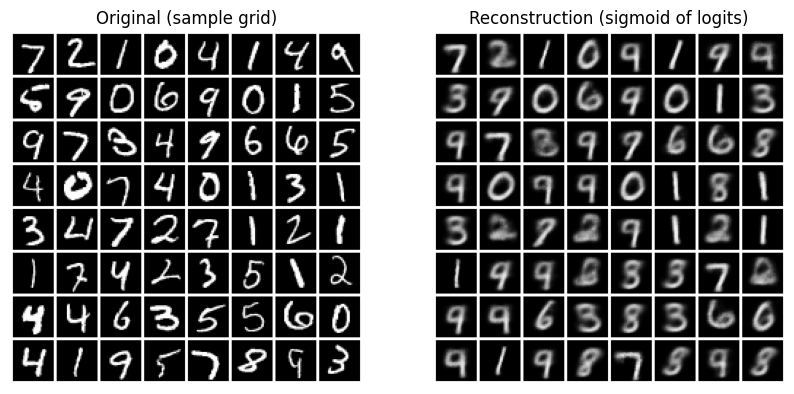

In [13]:
# Cell 5 — Visualize reconstructions & print reconstruction computation steps
# Run after training (Cell 4)

model.eval()
x_test, _ = next(iter(test_loader))
x_test = x_test.to(device)[:64]  # take 64 images
with torch.no_grad():
    x_logits, mu, logvar, z = model(x_test)
    x_recon = torch.sigmoid(x_logits)  # convert logits to probabilities

# Print shapes & one detailed computation
print("Shapes: x_test", x_test.shape, " x_recon", x_recon.shape, " mu", mu.shape)
# compute per-image BCE for first example manually and compare to compute_loss
first = 0
bce_criterion = nn.BCELoss(reduction='none')
pixelwise = bce_criterion(x_recon[first], x_test[first])  # per-pixel loss
sum_pixelwise = pixelwise.sum().item()
# compute KL for first image
kl_first = -0.5 * torch.sum(1 + logvar[first] - mu[first].pow(2) - logvar[first].exp()).item()
print(f"First image: manual recon_sum (sum of BCE pixels)={sum_pixelwise:.4f}, kl_sum={kl_first:.4f}")
loss_per_image, recon_avg, kl_avg = compute_loss(x_test, x_logits, mu, logvar, beta=config["beta"])
print(f"Batch-level average: recon_avg(per-image)={recon_avg:.4f}, kl_avg(per-image)={kl_avg:.4f}, loss_per_image={loss_per_image:.4f}")

# Plot a grid: original vs reconstructed
# Plot a grid: original vs reconstructed
n = 8
orig_grid = utils.make_grid(x_test[:n*n], nrow=n, pad_value=1.0)
recon_grid = utils.make_grid(x_recon[:n*n], nrow=n, pad_value=1.0)

# FIX: convert (3, H, W) → (H, W, 3)
orig_img = orig_grid.cpu().permute(1, 2, 0).numpy()
recon_img = recon_grid.cpu().permute(1, 2, 0).numpy()

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

axes[0].imshow(orig_img, cmap='gray')
axes[0].axis('off')
axes[0].set_title("Original (sample grid)")

axes[1].imshow(recon_img, cmap='gray')
axes[1].axis('off')
axes[1].set_title("Reconstruction (sigmoid of logits)")

plt.show()



Collected latent means for test set, shape: (10000, 2)


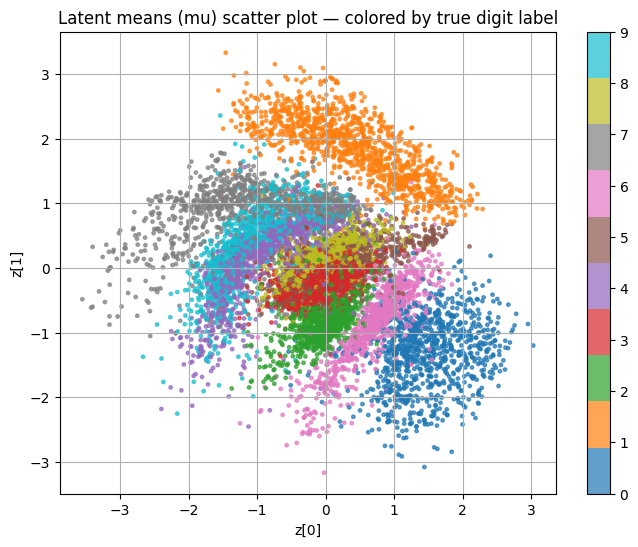

In [14]:
# Cell 6 — Latent visualizations: 2D scatter (if latent_dim=2) or 3D scatter+ellipsoid (if latent_dim=3)
# Run after Cell 5

# Collect latent means for test set to visualize
all_mu = []
all_labels = []
model.eval()
with torch.no_grad():
    for x_batch, y_batch in test_loader:
        x_batch = x_batch.to(device)
        _, mu_batch, _, _ = model(x_batch)
        all_mu.append(mu_batch.cpu().numpy())
        all_labels.append(y_batch.numpy())
all_mu = np.concatenate(all_mu, axis=0)
all_labels = np.concatenate(all_labels, axis=0)
print("Collected latent means for test set, shape:", all_mu.shape)

ld = config["latent_dim"]
if ld == 2:
    plt.figure(figsize=(8,6))
    scatter = plt.scatter(all_mu[:,0], all_mu[:,1], c=all_labels, cmap='tab10', s=6, alpha=0.7)
    plt.colorbar(scatter, ticks=range(10))
    plt.title("Latent means (mu) scatter plot — colored by true digit label")
    plt.xlabel("z[0]"); plt.ylabel("z[1]"); plt.grid(True)
    plt.show()
elif ld == 3:
    from mpl_toolkits.mplot3d import Axes3D
    fig = plt.figure(figsize=(9,7))
    ax = fig.add_subplot(111, projection='3d')
    p = ax.scatter(all_mu[:,0], all_mu[:,1], all_mu[:,2], c=all_labels, cmap='tab10', s=5, alpha=0.7)
    fig.colorbar(p, ax=ax)
    ax.set_title("Latent means (3D) colored by label")
    ax.set_xlabel("z0"); ax.set_ylabel("z1"); ax.set_zlabel("z2")
    plt.show()
else:
    # high-dim latent -> reduce by PCA for 2D plot
    from sklearn.decomposition import PCA
    pca = PCA(n_components=2)
    proj = pca.fit_transform(all_mu)
    plt.figure(figsize=(8,6))
    plt.scatter(proj[:,0], proj[:,1], c=all_labels, cmap='tab10', s=6, alpha=0.7)
    plt.title("PCA projection of latent means (colored by label)")
    plt.show()


Seed index: 0 label: 7
Posterior mean for seed (mu): [-1.4426122  1.1132518]


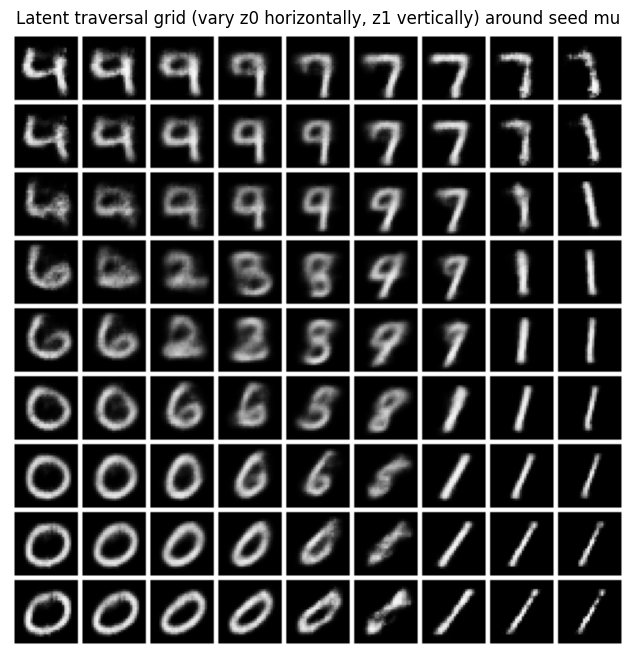

Interpolating between index 5 (label 1) and index 23 (label 5)


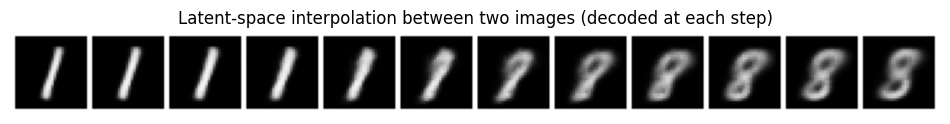

In [16]:
# Cell 7 — Latent traversals and interpolations (visual explanation prints + plots)
# Run after Cell 6

# Use decoded grid from varying two latent dims (works best when latent_dim >=2)
def decode_from_z_grid(z_grid):
    """z_grid: (N, latent_dim) numpy -> returns reconstructed images (N,1,28,28)"""
    model.eval()
    with torch.no_grad():
        z_tensor = torch.from_numpy(z_grid).float().to(device)
        x_logits = model.decode(z_tensor)
        x_recon = torch.sigmoid(x_logits).cpu()
    return x_recon

# 1) Traversal: take a seed image, compute its mu, vary each latent dim around mu
seed_idx = 0
x_seed, y_seed = test_dataset[seed_idx][0].unsqueeze(0).to(device), test_dataset[seed_idx][1]
print("Seed index:", seed_idx, "label:", y_seed)

with torch.no_grad():
    _, mu_seed, logvar_seed, _ = model(x_seed)

mu_seed = mu_seed.cpu().numpy().squeeze()
print("Posterior mean for seed (mu):", mu_seed)

# choose grid range around mu for two dims
span = np.linspace(-2.5, 2.5, 9)

if config["latent_dim"] >= 2:

    # vary z0 and z1, keep others at mu (if any)
    grid = []
    for v0 in span:
        for v1 in span:
            z = mu_seed.copy()
            z[0] = v0
            z[1] = v1
            grid.append(z)

    z_grid = np.stack(grid, axis=0)
    imgs = decode_from_z_grid(z_grid)  # (N,1,28,28)

    # show as grid
    n = len(span)
    grid_img = utils.make_grid(imgs, nrow=n, pad_value=1.0)

    plt.figure(figsize=(8,8))
    plt.imshow(grid_img.permute(1,2,0).cpu(), cmap='gray')
    plt.axis('off')
    plt.title("Latent traversal grid (vary z0 horizontally, z1 vertically) around seed mu")
    plt.show()

else:
    print("latent_dim < 2 — traversal not visualizable as 2D grid")


# 2) Interpolation between two test images in latent space
i1, i2 = 5, 23
x1 = test_dataset[i1][0].unsqueeze(0).to(device)
x2 = test_dataset[i2][0].unsqueeze(0).to(device)

with torch.no_grad():
    _, mu1, _, _ = model(x1)
    _, mu2, _, _ = model(x2)

mu1 = mu1.cpu().numpy().squeeze()
mu2 = mu2.cpu().numpy().squeeze()

print(f"Interpolating between index {i1} (label {test_dataset[i1][1]}) "
      f"and index {i2} (label {test_dataset[i2][1]})")

# linear interpolation in latent space
steps = 12
zs = np.array([
    ((1 - t) * mu1 + t * mu2)
    for t in np.linspace(0, 1, steps)
])

imgs_interp = decode_from_z_grid(zs)

grid_img2 = utils.make_grid(imgs_interp, nrow=steps, pad_value=1.0)

plt.figure(figsize=(12,2))
plt.imshow(grid_img2.permute(1,2,0).cpu(), cmap='gray')
plt.axis('off')
plt.title("Latent-space interpolation between two images (decoded at each step)")
plt.show()


# Summary, Tips & Next Steps

**You implemented and visualized a $\beta$-VAE on MNIST.** What we did in the notebook:

- Derived the $\beta$-VAE objective:  
  $ \mathcal{L} = -\mathbb{E}_{q_\phi}[\log p_\theta(x\mid z)] + \beta \operatorname{KL}(q_\phi(z\mid x)\|p(z)). $
- Implemented a small convolutional encoder/decoder and analytic KL formula.  
- Printed shapes and per-batch decomposition (reconstruction vs KL) so you can *see* how the loss is computed.  
- Visualized: reconstructions, latent scatter (2D / 3D), latent traversal grids, and interpolations.

**Practical tips:**
- To encourage disentanglement: increase $\beta$ (e.g., 4, 10) and train longer — but higher $\beta$ often reduces reconstruction quality.
- Good training schedule: pretrain with $\beta=1$ for good reconstructions, then increase $\beta$ (or use annealing strategies).
- Use more epochs (50–200) and GPU for high-quality disentanglement.
- For Bernoulli pixel modeling use BCE; for continuous images consider MSE or continuous decoders.

**Want next?** I can:
1. Produce a downloadable `.ipynb` with all cells filled and ready.  
2. Add logging (TensorBoard / WandB) and sample images saved per epoch.  
3. Provide a version using a VAE with FactorVAE / AnnealedVAE tricks for stronger disentanglement.  

Tell me which follow-up you want and I will add it.
